In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import json
import skimage

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline

import tensorflow as tf

cf = tf.ConfigProto()
cf.gpu_options.allow_growth = True
sess = tf.Session(config=cf)

def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

C:\Users\micke\Miniconda3\envs\mrcnn\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\micke\Miniconda3\envs\mrcnn\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\micke\Miniconda3\envs\mrcnn\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\micke\Miniconda3\envs\mrcnn\lib\site-packages\tensorflow\pyth

## Detection
---

In [2]:
class CalcMassDataset_no_normalize(utils.Dataset):

    def load_full_mammo_img(self, dataset_dir, subset):
        """Load a subset of the Balloon dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        
        self.add_class("AbnormalType", 1, "Calc")
        self.add_class("AbnormalType", 2, "Mass")

        # Train or validation dataset?
        assert subset in ["Crop_train", "Crop_val","Crop_test"]
        dataset_dir = os.path.join(dataset_dir, subset)
        print("path join : " ,dataset_dir)

        # Load annotations
        # VGG Image Annotator (up to version 1.6) saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        # Note: In VIA 2.0, regions was changed from a dict to a list.
        annotations = json.load(open(os.path.join(dataset_dir, "annotation_skip02.json")))
        annotations = list(annotations.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. These are stores in the
            # shape_attributes (see json format above)
            # The if condition is needed to support VIA versions 1.x and 2.x.
            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
            else:
                polygons = [r['shape_attributes'] for r in a['regions']] 

            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path,as_gray=True)
            height, width = image.shape[:2]

            self.add_image(
                "AbnormalType",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons)
    
    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a balloon dataset image, delegate to parent class.
        info = self.image_info[image_id]
        shapes = info['id']
        #print(polygons)
        #print(len(polygons))
        #print(polygons[0]["name"])
        
        count = len(info["polygons"])
        #print(shapes)
        #print(count)
        mask = np.zeros([info['height'], info['width'], count], dtype=np.uint8)
        
        for i, p in enumerate(info["polygons"]):
            #print(p)
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_point_y'], p['all_point_x'])
            mask[rr, cc, i] = 1
            
        # Map class names to class IDs.
        #print('shapes',shapes)
        class_ids = np.array([self.class_names.index(info["polygons"][0]["name"])]*count)
        return mask.astype(np.bool), class_ids.astype(np.int32)
    def load_image(self, image_id):
        """Load the specified image and return a [H,W,3] Numpy array.
        """
        # Load image
        image = skimage.io.imread(self.image_info[image_id]['path'])
        # If grayscale. Convert to RGB for consistency.
        if image.ndim != 3:
            image = skimage.color.gray2rgb(image)
        # If has an alpha channel, remove it for consistency
        if image.shape[-1] == 4:
            image = image[..., :3]
        return image

In [3]:
ROOT_DIR = r'E:\DataSet'
CALCMASS_DIR = os.path.join(ROOT_DIR, "CBIS-DDSM")

# Training dataset
dataset_train = CalcMassDataset_no_normalize()
dataset_train.load_full_mammo_img(CALCMASS_DIR, "Crop_train")
dataset_train.prepare()
print("Images: {}\nClasses: {}".format(len(dataset_train.image_ids), dataset_train.class_names))

ROOT_DIR = r'E:\DataSet'
CALCMASS_DIR = os.path.join(ROOT_DIR, "CBIS-DDSM")

# Validation dataset
dataset_val = CalcMassDataset_no_normalize()
dataset_val.load_full_mammo_img(CALCMASS_DIR, "Crop_val")
dataset_val.prepare()

print("Images: {}\nClasses: {}".format(len(dataset_val.image_ids), dataset_val.class_names))

ROOT_DIR = r'E:\DataSet'
CALCMASS_DIR = os.path.join(ROOT_DIR, "CBIS-DDSM")

# Test dataset
dataset_test = CalcMassDataset_no_normalize()
dataset_test.load_full_mammo_img(CALCMASS_DIR, "Crop_test")
dataset_test.prepare()

print("Images: {}\nClasses: {}".format(len(dataset_test.image_ids), dataset_test.class_names))

path join :  E:\DataSet\CBIS-DDSM\Crop_train
Images: 2355
Classes: ['BG', 'Calc', 'Mass']
path join :  E:\DataSet\CBIS-DDSM\Crop_val
Images: 523
Classes: ['BG', 'Calc', 'Mass']
path join :  E:\DataSet\CBIS-DDSM\Crop_test
Images: 107
Classes: ['BG', 'Calc', 'Mass']


In [4]:
class CalcMassConfig(Config):
    """
    Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 4

    # Number of classes (including background)
    NUM_CLASSES = 1 + 2  # background + 2 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_RESIZE_MODE = "square"
    IMAGE_MIN_DIM = 1024
    IMAGE_MAX_DIM = 1024
    IMAGE_CHANNEL_COUNT = 3
    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 200

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 10
    
config = CalcMassConfig()
#config.display()

In [5]:
class InferenceConfig(CalcMassConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights

model_path = os.path.join(r'E:\DataSet\CBIS-DDSM\model_log', "mask_rcnn_shapes_0200.h5")
#model_path = os.path.join(ROOT_DIR, ".h5")
#model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.
Loading weights from  E:\DataSet\CBIS-DDSM\model_log\mask_rcnn_shapes_0200.h5


25
original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  232.00000  uint8
image_meta               shape: (15,)                 min:    0.00000  max: 3480.00000  float64
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:  547.00000  max:  870.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  bool


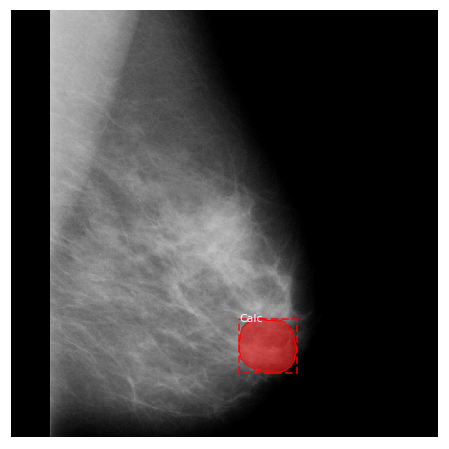

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  232.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  128.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.08847  max:    1.02591  float32
r['scores'] :  [0.9688364  0.88725376 0.82717234 0.8137152  0.75841564]
r['masks'].shape :  (1024, 1024, 5)
AP :  0.0
r['scores'] :  [0.9688364  0.88725376 0.82717234 0.8137152  0.75841564]
r['masks'].shape :  (1024, 1024, 5)
AP :  0.0


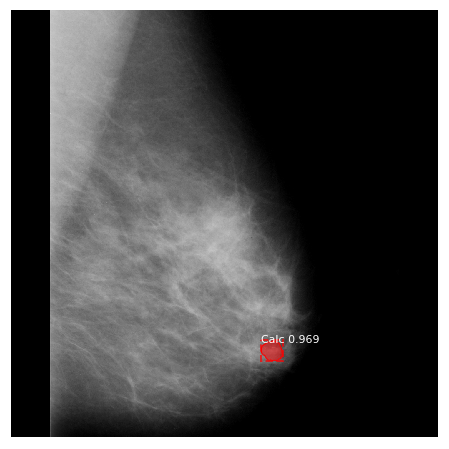

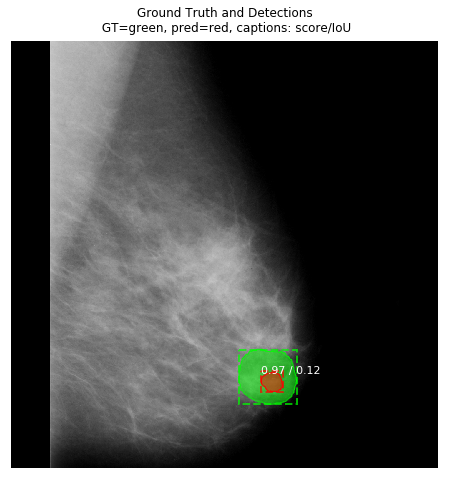

In [24]:
# Test on a random image

# Constant
score_threshold = 0.95
iou_thold = 0.5
#image_id = random.choice(dataset.image_ids)
image_id = 25
dataset = dataset_test



# Ground truth img
print(image_id)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset.class_names, figsize=(8, 8))

# Prediction
results = model.detect([original_image], verbose=1)

# r.keys() = rois(bbox), masks, class_ids, scores
r = results[0]

# filtering by scores
scores_thold = r["scores"] > score_threshold
cnt = 0
for i in scores_thold:
    if i ==True:
        cnt+=1

# if cnt ==0:
#     print("not detect")
# else:
visualize.display_instances(original_image, r['rois'][:cnt], r['masks'][...,:cnt], r['class_ids'][:cnt], 
                            dataset.class_names, r['scores'][:cnt], ax=get_ax())

AP, precisions, recalls, overlaps =\
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                             r["rois"][:cnt], r["class_ids"][:cnt], r["scores"][:cnt], r['masks'][...,:cnt],iou_threshold=iou_thold)
print("r['scores'] : ",r['scores'])
print("r['masks'].shape : ", r['masks'].shape)
print("AP : ",AP)

AP, precisions, recalls, overlaps =\
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                             r["rois"], r["class_ids"], r["scores"], r['masks'],iou_threshold=iou_thold)

print("r['scores'] : ",r['scores'])
print("r['masks'].shape : ", r['masks'].shape)
print("AP : ",AP)

visualize.display_differences(original_image,
                        gt_bbox, gt_class_id, gt_mask,
                        r["rois"][:cnt], r["class_ids"][:cnt], r["scores"][:cnt], r['masks'][...,:cnt],
                        dataset.class_names, title="", ax=get_ax(),
                        show_mask=True, show_box=True,
                        iou_threshold=iou_thold, score_threshold=score_threshold)

In [8]:
gt_class_id

array([2])

In [57]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights

#model_path = os.path.join(r'E:\DataSet\CBIS-DDSM\model_log', "mask_rcnn_shapes_0100.h5")
#model_path = os.path.join(r'E:\DataSet\CBIS-DDSM\model_log', "mask_rcnn_shapes_0200.h5")
model_path = os.path.join(r'E:\DataSet\CBIS-DDSM\model_log', "mask_rcnn_shapes_0300.h5")

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  E:\DataSet\CBIS-DDSM\model_log\mask_rcnn_shapes_0300.h5


In [6]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
dataset = dataset_test
score_threshold = 0.0
iou_thold = .0

image_ids = np.random.choice(dataset.image_ids, 100)
APs = []
mAP_list =[]
for i in range(4):
    print("iou_thold",iou_thold)
    for image_id in image_ids:
        # Load image and ground truth data
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, inference_config,
                                   image_id, use_mini_mask=False)
        molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
        # Run object detection
        results = model.detect([image], verbose=0)
        r = results[0]

        # filtering by scores
        scores_thold = r["scores"] > score_threshold
        cnt = 0
        for i in scores_thold:
            if i ==True:
                cnt+=1

        # Compute AP
        AP, precisions, recalls, overlaps =\
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                             r["rois"][:cnt], r["class_ids"][:cnt], r["scores"][:cnt], r['masks'][...,:cnt],iou_threshold=iou_thold)
        APs.append(AP)

    print("mAP: ", np.mean(APs))
    mAP_list.append(np.mean(APs))
    iou_thold += 0.25

iou_thold 0.0

mAP:  0.7299891776878595
iou_thold 0.25
mAP:  0.5926551782843216
iou_thold 0.5
mAP:  0.5175820846880483
iou_thold 0.75
mAP:  0.4125615635160363


50
original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (15,)                 min:    0.00000  max: 4518.00000  float64
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:  149.00000  max:  344.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  bool


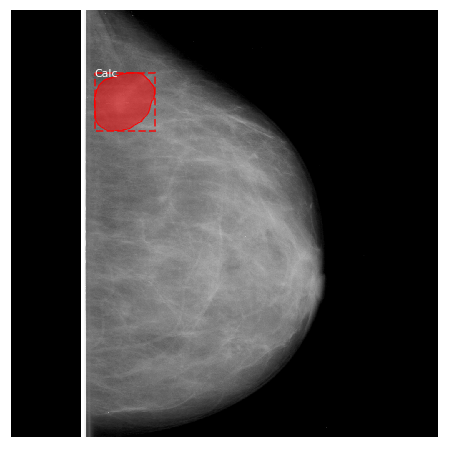

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.08847  max:    1.02591  float32
r['scores'] :  [0.9673464  0.95744944 0.94311935 0.9276376  0.90480983 0.79449314]
r['masks'].shape :  (1024, 1024, 6)
AP :  1.0
r['scores'] :  [0.9673464  0.95744944 0.94311935 0.9276376  0.90480983 0.79449314]
r['masks'].shape :  (1024, 1024, 6)
AP :  1.0


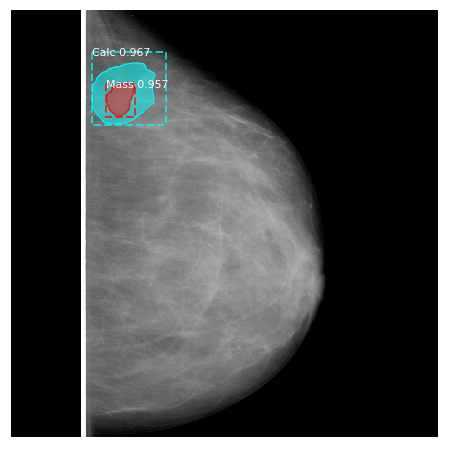

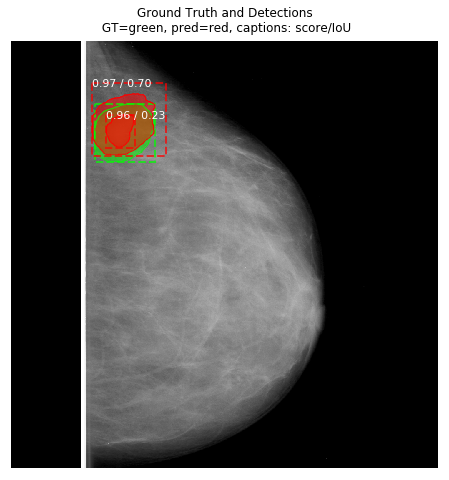

In [59]:
# Test on a random image

# Constant
score_threshold = 0.95
iou_thold = 0.5
dataset = dataset_test

# Load data
#image_id = random.choice(dataset.image_ids)
image_id = 50
# Ground truth img
print(image_id)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset.class_names, figsize=(8, 8))

# Prediction
results = model.detect([original_image], verbose=1)

# r.keys() = rois(bbox), masks, class_ids, scores
r = results[0]

# filtering by scores
scores_thold = r["scores"] > score_threshold
cnt = 0
for i in scores_thold:
    if i ==True:
        cnt+=1

# if cnt ==0:
#     print("not detect")
# else:
visualize.display_instances(original_image, r['rois'][:cnt], r['masks'][...,:cnt], r['class_ids'][:cnt], 
                            dataset.class_names, r['scores'][:cnt], ax=get_ax())

AP, precisions, recalls, overlaps =\
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                             r["rois"][:cnt], r["class_ids"][:cnt], r["scores"][:cnt], r['masks'][...,:cnt],iou_threshold=iou_thold)
print("r['scores'] : ",r['scores'])
print("r['masks'].shape : ", r['masks'].shape)
print("AP : ",AP)

AP, precisions, recalls, overlaps =\
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                             r["rois"], r["class_ids"], r["scores"], r['masks'],iou_threshold=iou_thold)

print("r['scores'] : ",r['scores'])
print("r['masks'].shape : ", r['masks'].shape)
print("AP : ",AP)

visualize.display_differences(original_image,
                        gt_bbox, gt_class_id, gt_mask,
                        r["rois"][:cnt], r["class_ids"][:cnt], r["scores"][:cnt], r['masks'][...,:cnt],
                        dataset.class_names, title="", ax=get_ax(),
                        show_mask=True, show_box=True,
                        iou_threshold=iou_thold, score_threshold=score_threshold)

# Cropping 이전자료

In [48]:
class CalcMassDataset_no_normalize(utils.Dataset):

    def load_full_mammo_img(self, dataset_dir, subset):
        """Load a subset of the Balloon dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        
        self.add_class("AbnormalType", 1, "Calc")
        self.add_class("AbnormalType", 2, "Mass")

        # Train or validation dataset?
        assert subset in ["Crop_train", "Crop_val","test_"]
        dataset_dir = os.path.join(dataset_dir, subset)
        print("path join : " ,dataset_dir)

        # Load annotations
        # VGG Image Annotator (up to version 1.6) saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        # Note: In VIA 2.0, regions was changed from a dict to a list.
        annotations = json.load(open(os.path.join(dataset_dir, "annotation01_skip02.json")))
        annotations = list(annotations.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. These are stores in the
            # shape_attributes (see json format above)
            # The if condition is needed to support VIA versions 1.x and 2.x.
            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
            else:
                polygons = [r['shape_attributes'] for r in a['regions']] 

            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path,as_gray=True)
            height, width = image.shape[:2]

            self.add_image(
                "AbnormalType",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons)
    
    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a balloon dataset image, delegate to parent class.
        info = self.image_info[image_id]
        shapes = info['id']
        #print(polygons)
        #print(len(polygons))
        #print(polygons[0]["name"])
        
        count = len(info["polygons"])
        #print(shapes)
        #print(count)
        mask = np.zeros([info['height'], info['width'], count], dtype=np.uint8)
        
        for i, p in enumerate(info["polygons"]):
            #print(p)
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_point_y'], p['all_point_x'])
            mask[rr, cc, i] = 1
            
        # Map class names to class IDs.
        #print('shapes',shapes)
        class_ids = np.array([self.class_names.index(info["polygons"][0]["name"])]*count)
        return mask.astype(np.bool), class_ids.astype(np.int32)
    def load_image(self, image_id):
        """Load the specified image and return a [H,W,3] Numpy array.
        """
        # Load image
        image = skimage.io.imread(self.image_info[image_id]['path'])
        # If grayscale. Convert to RGB for consistency.
        if image.ndim != 3:
            image = skimage.color.gray2rgb(image)
        # If has an alpha channel, remove it for consistency
        if image.shape[-1] == 4:
            image = image[..., :3]
        return image
    
# Test dataset
dataset_test = CalcMassDataset_no_normalize()
dataset_test.load_full_mammo_img(CALCMASS_DIR, "test_")
dataset_test.prepare()

print("Images: {}\nClasses: {}".format(len(dataset_test.image_ids), dataset_test.class_names))

path join :  E:\DataSet\CBIS-DDSM\test_
Images: 65
Classes: ['BG', 'Calc', 'Mass']


In [49]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights

#model_path = os.path.join(r'E:\DataSet\logs\model_log', "mask_rcnn_shapes_0100.h5")
# model_path = os.path.join(r'E:\DataSet\logs\model_log', "mask_rcnn_shapes_0200.h5")
model_path = os.path.join(r'D:\Gproject\Codes\Mask_RCNN_1.14\logs\shapes20200527T0447', "mask_rcnn_shapes_0100.h5")

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  D:\Gproject\Codes\Mask_RCNN_1.14\logs\shapes20200527T0447\mask_rcnn_shapes_0100.h5
Re-starting from epoch 100


In [50]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
dataset = dataset_test
score_threshold = 0.0
iou_thold = .0

image_ids = np.random.choice(dataset.image_ids, 100)
APs = []
mAP_list =[]
for i in range(4):
    print("iou_thold",iou_thold)
    for image_id in image_ids:
        # Load image and ground truth data
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, inference_config,
                                   image_id, use_mini_mask=False)
        molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
        # Run object detection
        results = model.detect([image], verbose=0)
        r = results[0]

        # filtering by scores
        scores_thold = r["scores"] > score_threshold
        cnt = 0
        for i in scores_thold:
            if i ==True:
                cnt+=1

        # Compute AP
        AP, precisions, recalls, overlaps =\
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                             r["rois"][:cnt], r["class_ids"][:cnt], r["scores"][:cnt], r['masks'][...,:cnt],iou_threshold=iou_thold)
        APs.append(AP)

    print("mAP: ", np.mean(APs))
    mAP_list.append(np.mean(APs))
    iou_thold += 0.25

iou_thold 0.0
mAP:  0.823
iou_thold 0.25
mAP:  0.6535833333333333
iou_thold 0.5
mAP:  0.539611111111111
iou_thold 0.75
mAP:  0.4222083333333333


16
original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (15,)                 min:    0.00000  max: 6511.00000  float64
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  328.00000  max:  626.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  bool


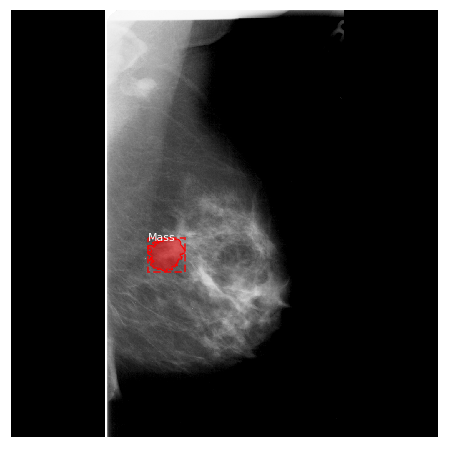

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.08847  max:    1.02591  float32
r['scores'] :  [0.995331   0.97507757 0.95521474 0.9157982  0.9000536  0.82915825
 0.8279634  0.75727075]
r['masks'].shape :  (1024, 1024, 8)
AP :  0.0
r['scores'] :  [0.995331   0.97507757 0.95521474 0.9157982  0.9000536  0.82915825
 0.8279634  0.75727075]
r['masks'].shape :  (1024, 1024, 8)
AP :  0.0


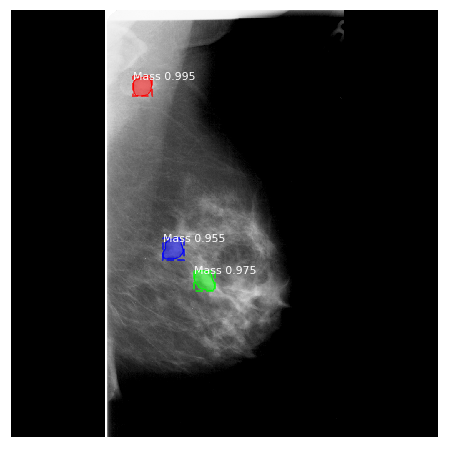

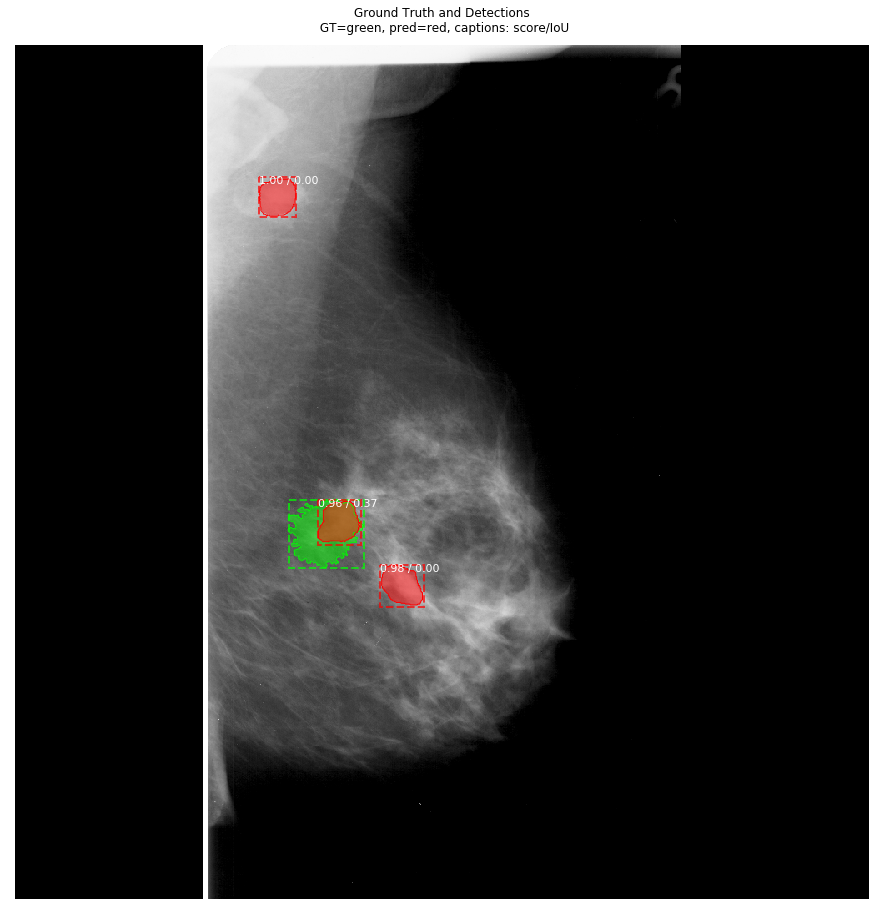

In [135]:
# Test on a random image

# Constant
score_threshold = 0.95
iou_thold = 0.5
dataset = dataset_test

# Load data
#image_id = random.choice(dataset.image_ids)
image_id =16
# Ground truth img
print(image_id)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset.class_names, figsize=(8, 8))

# Prediction
results = model.detect([original_image], verbose=1)

# r.keys() = rois(bbox), masks, class_ids, scores
r = results[0]

# filtering by scores
scores_thold = r["scores"] > score_threshold
cnt = 0
for i in scores_thold:
    if i ==True:
        cnt+=1

# if cnt ==0:
#     print("not detect")
# else:
visualize.display_instances(original_image, r['rois'][:cnt], r['masks'][...,:cnt], r['class_ids'][:cnt], 
                            dataset.class_names, r['scores'][:cnt], ax=get_ax())

AP, precisions, recalls, overlaps =\
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                             r["rois"][:cnt], r["class_ids"][:cnt], r["scores"][:cnt], r['masks'][...,:cnt],iou_threshold=iou_thold)
print("r['scores'] : ",r['scores'])
print("r['masks'].shape : ", r['masks'].shape)
print("AP : ",AP)

AP, precisions, recalls, overlaps =\
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                             r["rois"], r["class_ids"], r["scores"], r['masks'],iou_threshold=iou_thold)

print("r['scores'] : ",r['scores'])
print("r['masks'].shape : ", r['masks'].shape)
print("AP : ",AP)

visualize.display_differences(original_image,
                        gt_bbox, gt_class_id, gt_mask,
                        r["rois"][:cnt], r["class_ids"][:cnt], r["scores"][:cnt], r['masks'][...,:cnt],
                        dataset.class_names, title="", ax=None,
                        show_mask=True, show_box=True,
                        iou_threshold=iou_thold, score_threshold=score_threshold)

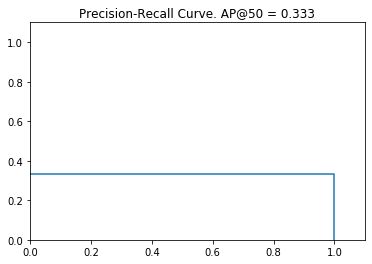

In [91]:
visualize.plot_precision_recall(AP, precisions, recalls)

In [74]:
 r["rois"], r["class_ids"], r["scores"], r['masks'],iou_threshold=iou_thold)

(1024, 1024, 11)

In [110]:
r['masks'][...,:2].shape

(1024, 1024, 2)